<h1>CellClassifier: performance on FlowCAP dataset</h1>

“Challenge 4: supervised approaches trained using human-provided gates” with 25% of the manual gates (that is, population membership labels) for each data set provided for training and tuning algorithms.

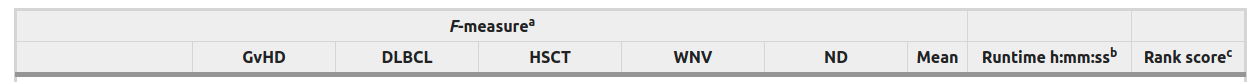
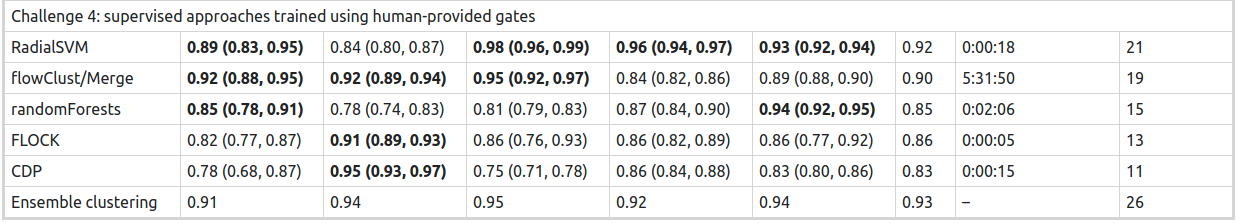

In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

In [2]:
from CytoPy.data.project import Project
from CytoPy.data.population import Population
from CytoPy.data.setup import global_init
from CytoPy.flow.cell_classifier import SklearnCellClassifier, KerasCellClassifier
global_init("cytopy_db")

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import logging
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
flowcap = Project.objects(project_id="FlowCAP").get()

In [5]:
cfse = flowcap.load_experiment("CFSE")
gvhd = flowcap.load_experiment("GvHD")
lymph = flowcap.load_experiment("Lymph")
ndd = flowcap.load_experiment("NDD")
stemcell = flowcap.load_experiment("StemCell")

<h2>Create dummy populations</h2>

In [6]:
def load_labels(exp, sample_id):
    return (pd.read_csv(f"/media/ross/extdrive/FlowCAP/FlowCAP1/Data/Labels/{exp}/{sample_id}.csv")
            .V1.values)

In [7]:
def create_populations(labels):
    populations = list()
    for i in np.unique(labels):
        idx = np.where(labels == i)[0]
        populations.append(Population(population_name=f"pop{i}",
                                      n=len(idx),
                                      parent="root",
                                      source="cluster",
                                      index=idx))
    return populations

In [8]:
def create_dummy_populations(experiment, experiment_dir_name):
    for fg in experiment.fcs_files:
        labels = load_labels(experiment_dir_name, fg.primary_id)
        populations = create_populations(labels)
        for p in populations:
            fg.add_population(p)
        fg.save()

In [24]:
create_dummy_populations(cfse, "CFSE")

In [25]:
create_dummy_populations(gvhd, "GvHD")

In [26]:
create_dummy_populations(lymph, "Lymph")

In [27]:
create_dummy_populations(ndd, "NDD")

In [28]:
create_dummy_populations(stemcell, "StemCell")

In [9]:
def sklearn_performance(experiment,
                        klass,
                        params,
                        scale: bool = True):
    f1_score = list()
    acc = list()
    for sample_id in tqdm(experiment.list_samples()):
        fg = experiment.get_sample(sample_id)
        classifier = SklearnCellClassifier(klass=klass,
                                   params=params,
                                   features=experiment.panel.list_channels(),
                                   target_populations=[f"pop{i}" for i in range(len(fg.populations)-1)],
                                   logging_level=logging.ERROR)
        classifier.load_training_data(experiment=experiment,
                                      reference=sample_id,
                                      root_population="root")
        classifier.build_model()
        classifier.scale()
        results = classifier.fit_train_test_split(test_frac=0.75,
                                                  metrics=["f1_weighted", 
                                                           "balanced_accuracy_score"])
        f1_score.append(results[0].get("test").get("f1_weighted"))
        acc.append(results[0].get("test").get("balanced_accuracy_score"))
    return f1_score, acc

In [10]:
def bootstrap_ci(x):
    ci = np.zeros(10000)
    for i in range(10000):
        ci[i] = np.mean(np.random.choice(x, size=len(x), replace=True))
    ci = np.sort(ci)
    return np.mean(ci), ci[250], ci[9750]

In [11]:
def print_stats(f1_score, acc):
    print("Balanced accuracy: {} [{} - {}]".format(*bootstrap_ci(acc)))
    print("F1 score (weighted): {} [{} - {}]".format(*bootstrap_ci(f1_score)))

In [12]:
def flowcap_performance(klass, params):
    print(f"============== {klass} ==============")
    print("--------------- CFSE ---------------")
    results = sklearn_performance(experiment=cfse, klass=klass, params=params)
    print_stats(*results)
    print("--------------- GvHD ---------------")
    results = sklearn_performance(experiment=gvhd, klass=klass, params=params)
    print_stats(*results)
    print("--------------- Lymph ---------------")
    results = sklearn_performance(experiment=lymph, klass=klass, params=params)
    print_stats(*results)
    print("--------------- NDD ---------------")
    results = sklearn_performance(experiment=ndd, klass=klass, params=params)
    print_stats(*results)
    print("--------------- StemCell ---------------")
    results = sklearn_performance(experiment=stemcell, klass=klass, params=params)
    print_stats(*results)
    print("=======================================")

<h2>Logistic Regression classifier</h2>

In [140]:
params = {"penalty": "none",
          "random_state": 42,
          "n_jobs": -1,
          "class_weight": "balanced"}
flowcap_performance("LogisticRegression", params)

============== LogisticRegression ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.8878044796036818 [0.8713492162433302 - 0.9051863202504777]
F1 score (weighted): 0.9148909579188603 [0.9073683386548519 - 0.922664385659028]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.8991641579273956 [0.8724670953862179 - 0.9266919031231367]
F1 score (weighted): 0.9388907487685164 [0.918001075079899 - 0.9591863177224765]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8666102892721623 [0.8457443655928346 - 0.8869161291605185]
F1 score (weighted): 0.9433893856616582 [0.930513420712609 - 0.954934078300236]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8517896372971252 [0.84401994455065 - 0.8585598354745116]
F1 score (weighted): 0.8196747392627636 [0.8102311073940166 - 0.8286419730187317]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8929774249301817 [0.8775369470557247 - 0.9078963309157303]
F1 score (weighted): 0.9680171687132321 [0.9602505951033394 - 0.9749368590612927]


<h2>Linear Discriminant Analysis</h2>

In [141]:
params = {"shrinkage": None}
flowcap_performance("LinearDiscriminantAnalysis", params)

============== LinearDiscriminantAnalysis ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.791369736179983 [0.7669398972195401 - 0.8162818788712356]
F1 score (weighted): 0.9224848199542123 [0.909574628859562 - 0.935071327533222]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.8368378888902924 [0.8029997148878535 - 0.8726247085255663]
F1 score (weighted): 0.9445416735378225 [0.9218570311250774 - 0.9659673699364001]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8123536508866668 [0.7887974333642671 - 0.8351449888289217]
F1 score (weighted): 0.9524670449463086 [0.9349149056608986 - 0.966302775844007]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.626882716005788 [0.616632485458028 - 0.6372407818905275]
F1 score (weighted): 0.811156209403925 [0.8037750566555025 - 0.8173653090398848]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8154501841731043 [0.7968195952305276 - 0.834349455054611]
F1 score (weighted): 0.9776486287967838 [0.970545214310784 - 0.9831523563086011]


<h2>Radial Support Vector Machine</h2>

In [145]:
params = {"kernel": "rbf", 
          "C": 1.0, 
          "gamma": "auto", 
          "class_weight": "balanced", 
          "random_state": 42,
          "cache_size": 8000}
flowcap_performance("SVC", params)

============== SVC ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.9464566578800541 [0.938737560487233 - 0.953346014381476]
F1 score (weighted): 0.9651888417259724 [0.9621754977799676 - 0.968365306143408]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.9449190752736302 [0.932901810679418 - 0.957359956341933]
F1 score (weighted): 0.9626499342995485 [0.9494613390251859 - 0.9758012309369132]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.9044501606666195 [0.8891575865401077 - 0.9185337456111555]
F1 score (weighted): 0.9674942811682966 [0.9601942514028526 - 0.9741042737887375]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8792492010301561 [0.8719344613211548 - 0.886417451948756]
F1 score (weighted): 0.9082348009724454 [0.9043373188091344 - 0.9120139602440341]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8836189068321151 [0.864566403268184 - 0.901060946425488]
F1 score (weighted): 0.9799438110390456 [0.9757260656992525 - 0.9838594500013496]


<h2>K Nearest Neighbours</h2>

In [142]:
params = {"n_neighbors": 30, 
          "n_jobs": -1}
flowcap_performance("KNeighborsClassifier", params)

============== KNeighborsClassifier ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.8128004791222644 [0.7840592297451011 - 0.8427871051924887]
F1 score (weighted): 0.9498726796700842 [0.9450576978514816 - 0.9546959321274003]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.8275596316483436 [0.806209833824016 - 0.8536883376923273]
F1 score (weighted): 0.9465423452747953 [0.9265639238165688 - 0.9650331006570995]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.720339492834544 [0.6950446444449409 - 0.7459758445244382]
F1 score (weighted): 0.9449174678516783 [0.9306090771664208 - 0.9577243138612773]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.4980951509916803 [0.48100186917468385 - 0.5149302950831581]
F1 score (weighted): 0.8933169203810448 [0.8873283396610336 - 0.8993080473617197]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.7155256911963445 [0.6834374254110196 - 0.7448359917627996]
F1 score (weighted): 0.9700679392332325 [0.9622514095680266 - 0.9762297048223088]


<h2>XGBoost</h2>

In [144]:
params = {"random_state": 42}
flowcap_performance("XGBClassifier", params)

============== XGBClassifier ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.936018250611199 [0.9253101955573495 - 0.9472175622222566]
F1 score (weighted): 0.9856260646128341 [0.9842465034386586 - 0.9872673777681993]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.9477874177902409 [0.9315109183409147 - 0.9639569736668402]
F1 score (weighted): 0.9852219182626973 [0.9766477026560011 - 0.9925169351674591]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8649436708376131 [0.8389682321715404 - 0.8888236093027616]
F1 score (weighted): 0.9786780363157642 [0.9741634584722649 - 0.982830539695767]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8975344984515489 [0.8843248360840643 - 0.909928677561065]
F1 score (weighted): 0.9886924711788956 [0.9878866856129559 - 0.9892389002802381]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.8723194826500763 [0.8530958576665593 - 0.8903113878456641]
F1 score (weighted): 0.9892625666745033 [0.9875178617649815 - 0.990961216853645]


<h2>Feed-forward deep neural network</h2>

In [13]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.regularizers import l2
import math

In [19]:
def step_decay(epoch):
    '''
    Learning rate schedule.
    Code taken from https://github.com/lkshan/DeepCYTOF-with-Synthetic-gradient
    '''
    initial_lrate = 1e-3 # u0
    drop = 0.5 # delta
    epochs_drop = 50.0 # T
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

def keras_performance(experiment,
                      scale: bool = True,
                      l2_penalty=1e-4,
                      activation="softplus",
                      hidden_layer_sizes: list or None = None):
    hidden_layer_sizes = hidden_layer_sizes or [12, 6, 3]
    optimizer = RMSprop(lr=0.0)
    lrate = LearningRateScheduler(step_decay)
    
    f1_score = list()
    acc = list()
    
    for sample_id in tqdm(experiment.list_samples()):
        fg = experiment.get_sample(sample_id)
        pops = [f"pop{i}" for i in range(len(fg.populations)-1)]
        classifier = KerasCellClassifier(optimizer=optimizer,
                                         loss="categorical_crossentropy",
                                         metrics=[AUC(), Accuracy()],
                                         features=experiment.panel.list_channels(),
                                         target_populations=pops,
                                         logging_level=logging.ERROR)
        classifier.load_training_data(experiment=experiment,
                                      reference=sample_id,
                                      root_population="root")
        layer_params = [{"units": i,
                         "activation": activation,
                         "kernel_regularizer": l2(l2_penalty)} for i in hidden_layer_sizes]
        layer_params = [{}] + layer_params + [{"units": len(np.unique(classifier.y)) + 1,
                                               "activation": "softmax"}]
        classifier.build_model(layers=["Input", "Dense", "Dense", "Dense", "Dense"],
                               layer_params=layer_params,
                               input_shape=None)
        classifier.scale()
        lrate = LearningRateScheduler(step_decay)
        results = classifier.fit_train_test_split(test_frac=0.75,
                                                  metrics=["f1_weighted", 
                                                           "balanced_accuracy_score"],
                                                  epochs=80,
                                                  batch_size=128,
                                                  shuffle=True,
                                                  validation_split=0.1,
                                                  verbose=0,
                                                  callbacks=[lrate,
                                                             EarlyStopping(monitor = 'val_loss',
                                                                           patience = 25, 
                                                                           mode = 'auto')])
        f1_score.append(results[0].get("test").get("f1_weighted"))
        acc.append(results[0].get("test").get("balanced_accuracy_score"))
    return f1_score, acc

In [22]:
def flowcap_performance():
    print(f"============== Keras Deep Neural Net ==============")
    print("--------------- CFSE ---------------")
    results = keras_performance(experiment=cfse)
    print_stats(*results)
    print("--------------- GvHD ---------------")
    results = keras_performance(experiment=gvhd)
    print_stats(*results)
    print("--------------- Lymph ---------------")
    results = keras_performance(experiment=lymph)
    print_stats(*results)
    print("--------------- NDD ---------------")
    results = keras_performance(experiment=ndd)
    print_stats(*results)
    print("--------------- StemCell ---------------")
    results = keras_performance(experiment=stemcell)
    print_stats(*results)
    print("=======================================")

In [23]:
flowcap_performance()

============== Keras Deep Neural Net ==============
--------------- CFSE ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

Balanced accuracy: 0.9334976016566339 [0.9177670009496919 - 0.948405724333018]
F1 score (weighted): 0.9852057240179983 [0.98231963546813 - 0.9879064797723948]
--------------- GvHD ---------------


  0%|          | 0/12 [00:00<?, ?it/s]

Balanced accuracy: 0.8259234124315562 [0.7786709668086523 - 0.8738977173840636]
F1 score (weighted): 0.955309998773723 [0.9395676982573223 - 0.9716701211713366]
--------------- Lymph ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.6975534797771068 [0.6485351365171235 - 0.7454847076077171]
F1 score (weighted): 0.9323604006245596 [0.9088992337408212 - 0.9533690015260342]
--------------- NDD ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.5324926548523279 [0.5158408286393913 - 0.5487258341470529]
F1 score (weighted): 0.9237464668487213 [0.9199741306277953 - 0.9272872817405785]
--------------- StemCell ---------------


  0%|          | 0/30 [00:00<?, ?it/s]

Balanced accuracy: 0.721683638981999 [0.6776304450837386 - 0.7596809374402359]
F1 score (weighted): 0.9709376022342668 [0.9597844304218542 - 0.9791437900142269]
